In [ ]:
# Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Modelos preentrenados
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Resizing, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input

### 🔨 Preparación del los datos
- Carga del dataset
    - Mostramos informacion relevante de las imagenes
- Preprocesamiento de los datos:
    - Normalizacion de las imagenes
    - Conversion de labels a formato one-hot

In [ ]:
# Cargamos el dataset
( X_train, y_train ), ( X_test, y_test ) = cifar10.load_data()

# Mostramos la forma de los datos
print( f'X_train shape: {X_train.shape}' )
print( f'y_train shape: {y_train.shape}' )
print( f'X_test shape: {X_test.shape}' )
print( f'y_test shape: {y_test.shape}' )


etiquetas_unicas = np.unique(y_train)
print(f'Etiquetas únicas: {etiquetas_unicas}')



X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
X_train: [[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80 

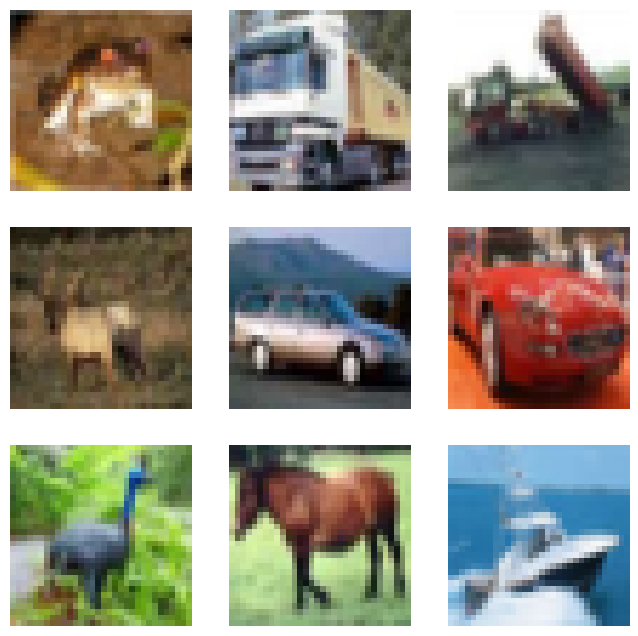

In [8]:
# Mostramos las primeras 6 imagenes de dataset
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

In [ ]:
# Normalizamos las imagenes
# X_train = X_train / 255.0
# X_test = X_test / 255.0

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# Convertimos las etiquetas a one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [11]:
# Mostramos las etiquetas convertidas a one-hot encoding
print(f'y_train: {y_train[0]}')

y_train: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
# Redimensionamos las imagenes para que tengan la forma (224, 224, 3)
# VGG16 espera imágenes de 224x224, así que las escalamos.
input_layer = Input(shape=(32, 32, 3))  # Entrada original de CIFAR-100
resized_layer = Resizing(224, 224)(input_layer)  # Redimensionar a 224x224


### 🧠 Implementación de la red neuronal preentrenada
- Arquitectura:
    - Utilizaremos los modelos VGG16, ResNet50 e InceptionV3.
    - Preparacion de la arquitectura
    - Construccion de los modelos VGG16, ResNet50 e InceptionV3
    - Compilacion utilizadon el optimizador Adam y la función de pérdida categorical_crossentropy

In [ ]:
# Cargamos el modelo preentrenado
vgg16_model = VGG16(include_top=False, input_tensor=resized_layer, weights='imagenet')

# Congelamos las capas del modelo base
for layer in vgg16_model.layers:
    layer.trainable = False

# Añadimos nuestras propia capa de clasificación
x = Flatten()(vgg16_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

model = Model(input_layer, x)

In [ ]:
# Compilamos el modelo
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Entrenamos el modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

In [ ]:
# Evaluamos el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Mostramos la evolución del entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Añadimos la matriz de confusión multiclase
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Predecimos las etiquetas para el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Mostramos la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=etiquetas_unicas)
disp.plot(cmap="Blues")
plt.show()